In [63]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

In [49]:
def read_data(file):
    filepaths = glob.glob("../data/tidy/" + file + "*.csv")
    df = pd.concat(map(lambda x: pd.read_csv(x, index_col=0, parse_dates=True), filepaths), sort=False)
    df.sort_index(inplace=True)
    df = df.resample("D").sum()
    return df

In [50]:
df = read_data("acetaminophen")

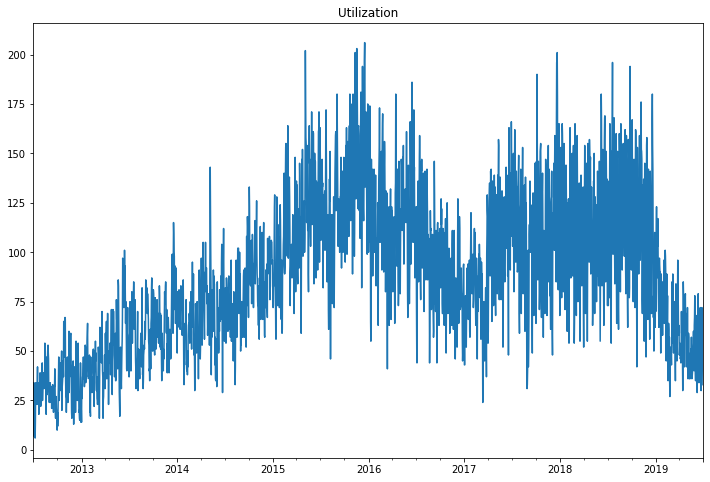

In [51]:
ax = df.plot(legend=False, figsize=(12, 8), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

# ACF and PACF

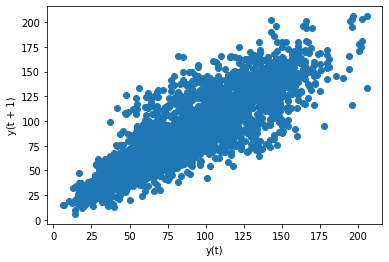

In [53]:
lag_plot(df["Y"]);

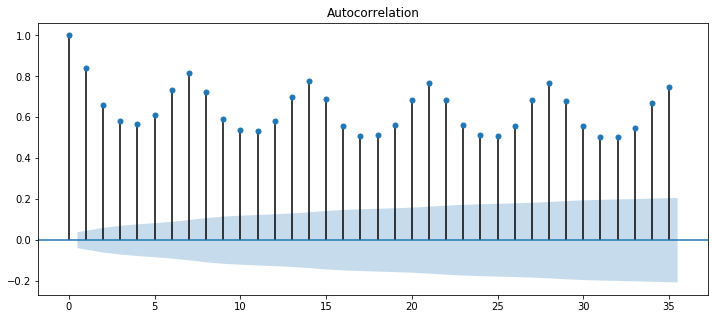

In [54]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df["Y"], ax=ax);

In [55]:
# data is not stationary if p-value > 0.05
adfuller(df["Y"].dropna(), autolag='AIC')[1]

0.225481412871869

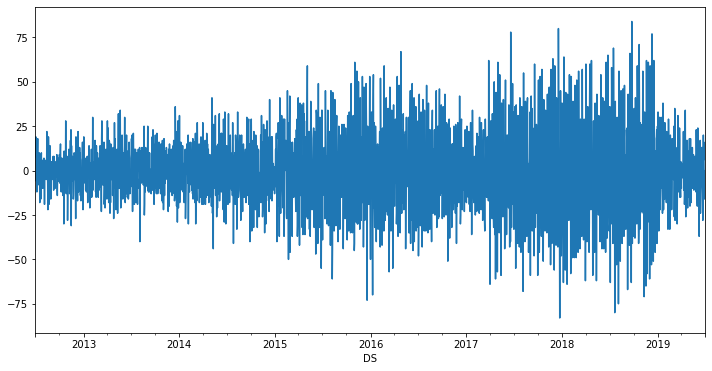

In [56]:
df_diff = df.copy()
df_diff["Y"] = diff(df_diff["Y"], k_diff=1)
df_diff["Y"].plot(figsize=(12, 6))

In [58]:
adfuller(df_diff["Y"].dropna(), autolag='AIC')[1]

8.930716935088746e-28

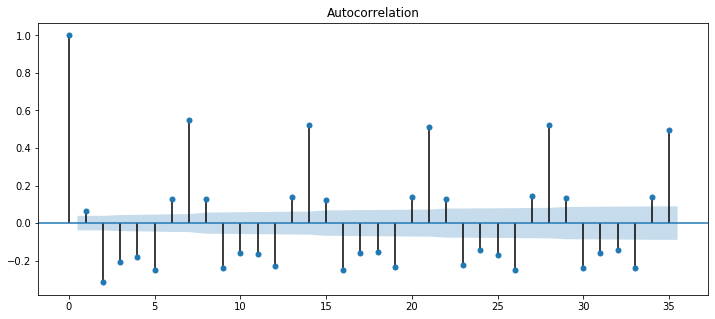

In [59]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_diff["Y"].dropna(), ax=ax);

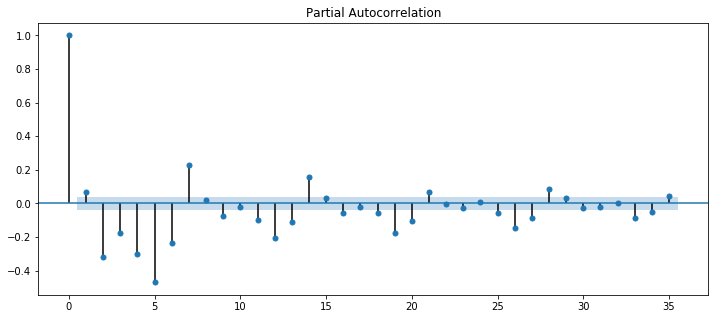

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Y"].dropna(), ax=ax);

# Train-Test-Split

In [71]:
n_pred = 90
l = len(df) - n_pred
df_train = df.iloc[:l]
df_test = df.iloc[l:]

# AR Model

In [69]:
model_ar = AR(df_train["Y"])
fit_ar = model_ar.fit(method="cmle")
max_lags = fit_ar.k_ar
print(f'Lag: {max_lags}')

Lag: 27


In [65]:
preds_ar = fit_ar.predict(start=len(df_train), end=len(df) - 1, dynamic=False).rename('AR Predictions')

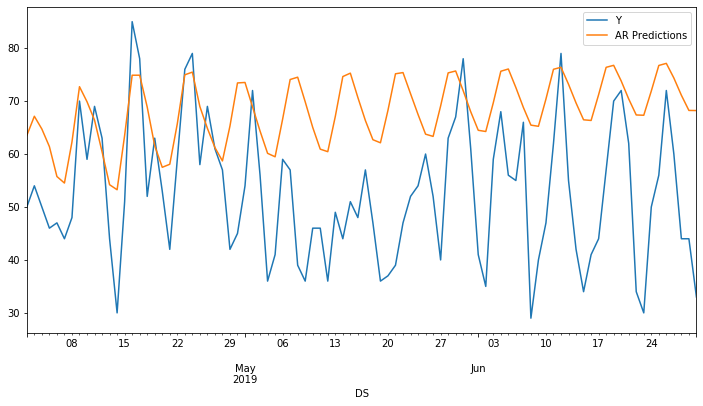

In [66]:
df_test["Y"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

In [68]:
print(f'MSE: {mean_squared_error(df_test["Y"], preds_ar):11.10}')
print(f'RMSE: {rmse(df_test["Y"], preds_ar):11.10}')
print(f'AIC: {fit_ar.aic:6.5}')

MSE:   369.75133
RMSE: 19.22891911
AIC: 5.4391


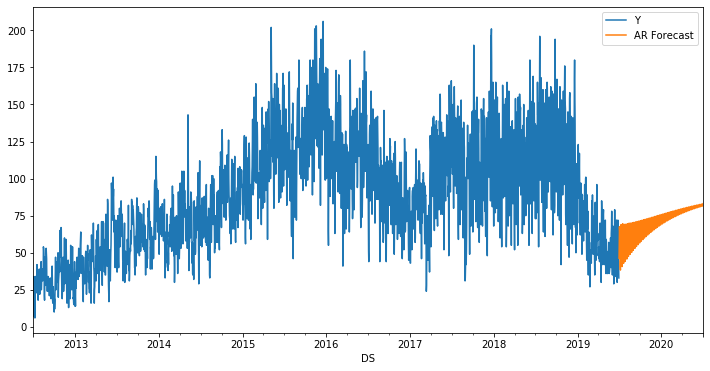

In [70]:
model_ar = AR(df["Y"])
fit_ar = model_ar.fit(maxlag=max_lags, method="cmle")
preds_ar = fit_ar.predict(start=len(df), end=len(df) + 366, dynamic=False).rename('AR Forecast')
df["Y"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

# ARIMA Model

In [72]:
auto_mod = auto_arima(
    df["Y"], 
    start_p=0,
    start_q=0,
    seasonal=False, 
    stepwise=False,
    suppress_warnings=True,
    error_action="ignore"
)
auto_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2555
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -10441.515
Method:                       css-mle   S.D. of innovations             14.384
Date:                Thu, 11 Jul 2019   AIC                          20907.031
Time:                        17:53:52   BIC                          20977.180
Sample:                             1   HQIC                         20932.470
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.036      0.278      0.781      -0.061       0.081
ar.L1.D.y      1.3986      0.021     66.549      0.000       1.357       1.440
ar.L2.D.y     -1.9213      0.017   -113.300      0.000      -1.955      -1.888
ar.L3.D.y      1.6618      0.030     54.838      0.000       1.602       1.721
ar.L4.D.y     -1.4749      0.017    -87.692      0.000      -1.508      -1.442
ar.L5.D.y      0.5961      0.021     28.637      0.000       0.555       0.637
ma.L1.D.y     -1.7305      0.012   -144.186      0.000      -1.754      -1.707
ma.L2.D.y      2.1348      0.016    133.352      0.000       2.103       2.166
ma.L3.D.y     -2.0828      0.019   -108.437      0.000      -2.120      -2.045
ma.L4.D.y      1.6576      0.015    111.039      0.000       1.628       1.687
ma.L5.D.y     -0.8854      0.011    -83.000      0.000      -0.906      -0.865
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2229           -0.9757j            1.0008           -0.2857
AR.2           -0.2229           +0.9757j            1.0008            0.2857
AR.3            0.6237           -0.7825j            1.0007           -0.1429
AR.4            0.6237           +0.7825j            1.0007            0.1429
AR.5            1.6725           -0.0000j            1.6725           -0.0000
MA.1           -0.2275           -0.9893j            1.0151           -0.2860
MA.2           -0.2275           +0.9893j            1.0151            0.2860
MA.3            1.0555           -0.0000j            1.0555           -0.0000
MA.4            0.6358           -0.7963j            1.0190           -0.1428
MA.5            0.6358           +0.7963j            1.0190            0.1428
-----------------------------------------------------------------------------
"""

In [73]:
model_arima = ARIMA(df_train["Y"], order=auto_mod.order)
fit_arima = model_arima.fit()

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [74]:
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

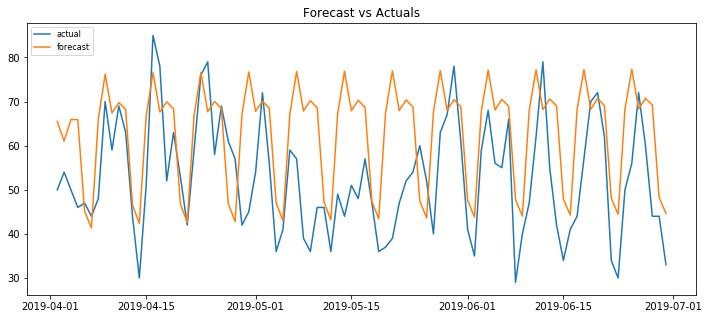

In [75]:
plt.figure(figsize=(12, 5))
#plt.plot(train_set, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [76]:
print(f'MSE: {mean_squared_error(df_test["Y"], fc_series):11.10}')
print(f'RMSE: {rmse(df_test["Y"], fc_series):11.10}')

MSE: 238.6641777
RMSE: 15.44875975


In [79]:
model_arima = ARIMA(df["Y"], order=auto_mod.order)
fit_arima = model_arima.fit()
n_pred = 366
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
idx = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_pred, freq="D")
fc_series = pd.Series(fc, index=idx)
lower_series = pd.Series(conf[:, 0], index=idx)
upper_series = pd.Series(conf[:, 1], index=idx)

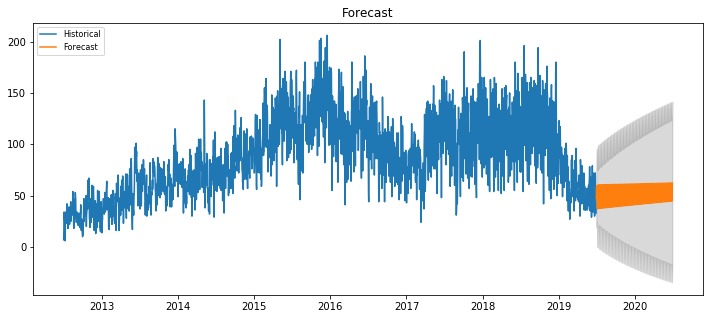

In [80]:
plt.figure(figsize=(12, 5))
plt.plot(df, label='Historical')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()